In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror
import narrom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
trajectories = narrom.utils.load_trajectories(filename='../trajectories_n_kmax=80.npz')
derivs = narrom.utils.load_trajectories(filename='../derivs_n_kmax=80.npz')

In [10]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.standardize_scaler(1.0)
transformer = narrom.transformer.ELM_features(ELM_nodes=1000)
optimizer = narrom.optimizer.ridge(alpha=10.**-3)

model = noror.noror(trajectories, derivs, rdim=15, VAR_l=1, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  15
VAR_l:  1
train shape:  (40000, 1016)
target shape:  (40000, 80)
weights shape:  (1016, 80)


In [57]:
ind = 71

test_trajectory = trajectories[ind]
truth = derivs[ind]

pred = model.predict(test_trajectory)

print( model.get_error(test_trajectory,truth,pred,norm='NF') ) 
print( model.get_error(test_trajectory,truth,norm='NF') ) 
print( model.get_error(truth=truth, pred=pred, norm='max') ) 

1.888220247866866e-06
1.888220247866866e-06
2.9665802518628802e-05


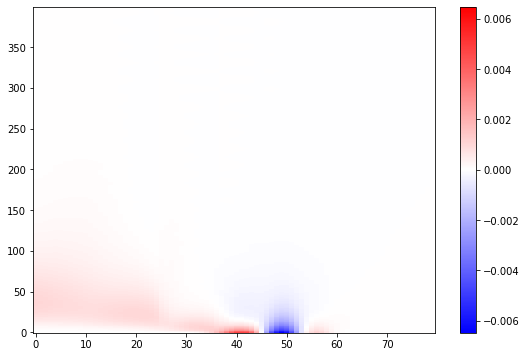

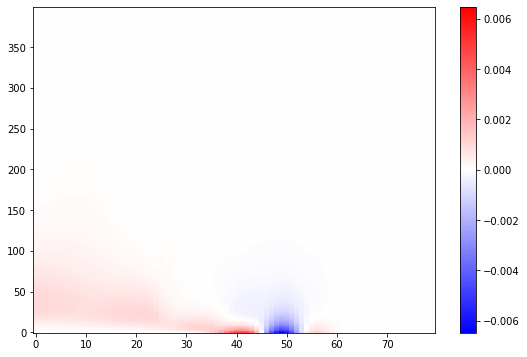

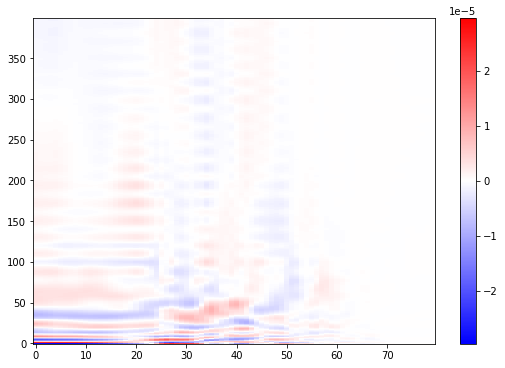

In [58]:
import matplotlib.colors as colors

plt.imshow(truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

plt.imshow(pred, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


plt.imshow(pred-truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


In [59]:
init = test_trajectory[0]

dt = 1.

Tmax = 2000.0

n_Tmax = int(Tmax/dt)

sol = np.zeros((n_Tmax,init.size))
sol[0] = init

for j in range(1,sol.shape[0]):
    sol[j] = sol[j-1] + dt*model.predict(sol[j-1])


5
(400, 80)


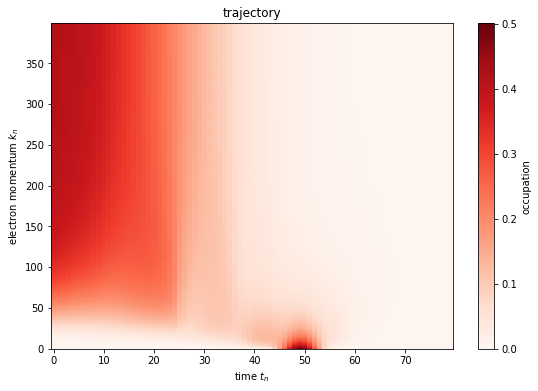

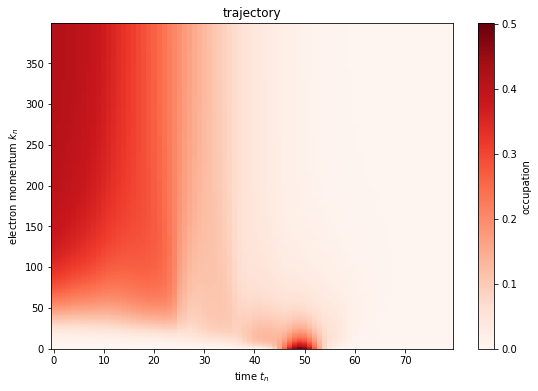

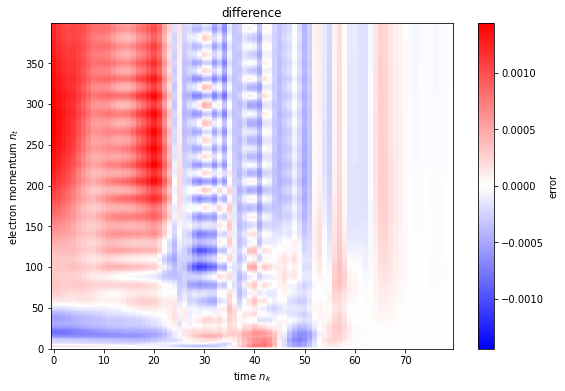

In [60]:
sample_step = int(5./dt)
print(sample_step)

ssol = sol[::sample_step]

print(ssol.shape)


narrom.utils.plot_trajectory(test_trajectory)

narrom.utils.plot_trajectory(ssol)

narrom.utils.plot_difference(truth=test_trajectory, test=ssol)